In [25]:
import datetime
from src import CompanyDetails, FindValues, Analyse,PredictValues, SharePricePrediction
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Input

from keras.optimizers import Adam

In [26]:
model = load_model("model_2.keras")
c_name = 'ONGC'
pow_details = CompanyDetails(c_name)
pow_share_price_df = pow_details.sharePriceRange('10y')
pow_share_price_df['Date'] = pow_share_price_df['Date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d')).sort_index()
pow_share_price_df.index = pow_share_price_df.pop('Date')
print(pow_share_price_df)

             Close      ema100      ema200
Date                                      
2015-03-30  127.08  127.080000  127.080000
2015-03-31  123.51  127.009307  127.044478
2015-04-01  123.55  126.940806  127.009707
2015-04-06  127.90  126.959800  127.018565
2015-04-07  128.61  126.992477  127.034401
...            ...         ...         ...
2025-03-24  243.83  246.096772  249.495804
2025-03-25  242.25  246.020598  249.423706
2025-03-26  239.72  245.895834  249.327152
2025-03-27  242.17  245.822055  249.255937
2025-03-28  246.38  245.833103  249.227320

[2470 rows x 3 columns]


In [28]:
def create_windows_for_inference(df, window_size=5):
    """
    Similar to create_windows_for_company but 
    doesn't produce 'y' if you want purely forward predictions.
    
    If you do want to evaluate, you can keep the target creation as well.
    """
    X = []
    df = df.sort_index()
    
    close_vals = df['Close'].values
    ema_vals   = df['ema200'].values
    
    for i in range(len(df) - window_size):
        window = []
        for j in range(window_size):
            window.append([close_vals[i+j], ema_vals[i+j]])
        X.append(window)
    
    return np.array(X)

In [29]:
window_size = 5
pow_infer = create_windows_for_inference(pow_share_price_df, window_size=5)
print(pow_infer)

[[[127.08       127.08      ]
  [123.51       127.04447761]
  [123.55       127.00970669]
  [127.9        127.01856533]
  [128.61       127.0344005 ]]

 [[123.51       127.04447761]
  [123.55       127.00970669]
  [127.9        127.01856533]
  [128.61       127.0344005 ]
  [126.19       127.02599851]]

 [[123.55       127.00970669]
  [127.9        127.01856533]
  [128.61       127.0344005 ]
  [126.19       127.02599851]
  [125.04       127.00623733]]

 ...

 [[232.57       249.76548205]
  [235.59       249.62443247]
  [242.42       249.55274658]
  [243.83       249.49580383]
  [242.25       249.42370627]]

 [[235.59       249.62443247]
  [242.42       249.55274658]
  [243.83       249.49580383]
  [242.25       249.42370627]
  [239.72       249.32715198]]

 [[242.42       249.55274658]
  [243.83       249.49580383]
  [242.25       249.42370627]
  [239.72       249.32715198]
  [242.17       249.25593654]]]


In [30]:
print(model.input_shape)

(None, 5, 2)


In [31]:
print(pow_infer.shape)

(2465, 5, 2)


In [32]:
pow_prediction = model.predict(pow_infer)
pow_pred_detes = pow_share_price_df.index[window_size:]

pow_result_df = pd.DataFrame()
pow_result_df['Date'] = pow_pred_detes
pow_result_df['Close'] = pow_prediction.flatten()
pow_result_df['ema200'] = pow_prediction.flatten()
pow_result_df.set_index('Date', inplace=True)
print(pow_result_df)

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
                 Close      ema200
Date                              
2015-04-08  124.107681  124.107681
2015-04-09  123.300789  123.300789
2015-04-10  123.512825  123.512825
2015-04-13  124.578575  124.578575
2015-04-15  124.655952  124.655952
...                ...         ...
2025-03-24  241.365891  241.365891
2025-03-25  240.774277  240.774277
2025-03-26  241.831253  241.831253
2025-03-27  242.953659  242.953659
2025-03-28  244.574799  244.574799

[2465 rows x 2 columns]


In [8]:
print(min(pow_result_df['Close']))
print(max(pow_result_df['Close']))

49.89052963256836
294.4985046386719


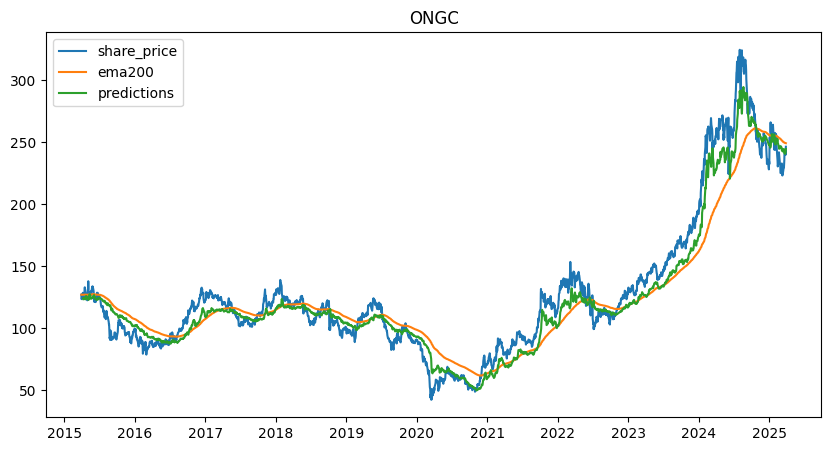

In [9]:
plt.figure(figsize=(10, 5))
plt.title(c_name)
plt.plot(pow_share_price_df.index, pow_share_price_df['Close'])
plt.plot(pow_share_price_df.index, pow_share_price_df['ema200'])
plt.plot(pow_result_df.index, pow_result_df['Close'])
plt.legend(['share_price', 'ema200', 'predictions'])

In [10]:
pow_future_year = 5
offset_ratio = 0.05
pow_last_row = pow_share_price_df.iloc[-1]
pow_know_date = pow_share_price_df.index[-1]
pow_last_close = pow_last_row['Close']
pow_last_ema = pow_last_row['ema200']

pow_last_window = pow_share_price_df[['Close', 'ema200']].tail(window_size).to_numpy()
print(pow_last_window)
print(pow_last_window.shape)

[[243.83       249.49580383]
 [242.25       249.42370627]
 [239.72       249.32715198]
 [242.17       249.25593654]
 [246.38       249.22732026]]
(5, 2)


In [11]:
pow_future_months = []
pow_current_date = pow_share_price_df.index[-1]

for _ in range(pow_future_year * 12):
    year, month = pow_current_date.year, pow_current_date.month
    month += 1
    if month > 12:
        month = 1
        year += 1
    pow_current_date = datetime.datetime(year=year, month=month, day=1)
    pow_future_months.append(pow_current_date)

for date in pow_future_months:
    print(date)

2025-04-01 00:00:00
2025-05-01 00:00:00
2025-06-01 00:00:00
2025-07-01 00:00:00
2025-08-01 00:00:00
2025-09-01 00:00:00
2025-10-01 00:00:00
2025-11-01 00:00:00
2025-12-01 00:00:00
2026-01-01 00:00:00
2026-02-01 00:00:00
2026-03-01 00:00:00
2026-04-01 00:00:00
2026-05-01 00:00:00
2026-06-01 00:00:00
2026-07-01 00:00:00
2026-08-01 00:00:00
2026-09-01 00:00:00
2026-10-01 00:00:00
2026-11-01 00:00:00
2026-12-01 00:00:00
2027-01-01 00:00:00
2027-02-01 00:00:00
2027-03-01 00:00:00
2027-04-01 00:00:00
2027-05-01 00:00:00
2027-06-01 00:00:00
2027-07-01 00:00:00
2027-08-01 00:00:00
2027-09-01 00:00:00
2027-10-01 00:00:00
2027-11-01 00:00:00
2027-12-01 00:00:00
2028-01-01 00:00:00
2028-02-01 00:00:00
2028-03-01 00:00:00
2028-04-01 00:00:00
2028-05-01 00:00:00
2028-06-01 00:00:00
2028-07-01 00:00:00
2028-08-01 00:00:00
2028-09-01 00:00:00
2028-10-01 00:00:00
2028-11-01 00:00:00
2028-12-01 00:00:00
2029-01-01 00:00:00
2029-02-01 00:00:00
2029-03-01 00:00:00
2029-04-01 00:00:00
2029-05-01 00:00:00


In [12]:
alpha = 2 / 201.0
pow_future_close = []
pow_future_ema = []

pow_current_window = pow_last_window.copy()
for _ in range(pow_future_year * 12):
    input_data = np.expand_dims(pow_current_window, axis=0)
    pred_close = model.predict(input_data)
    pred_close_val = pred_close.flatten()[0]        #convert multi dim array to 1D array

    last_ema = pow_current_window[-1, 1]
    new_ema = (pred_close_val - last_ema) * alpha + last_ema

    pow_future_close.append(pred_close_val)
    pow_future_ema.append(new_ema)

    new_row = np.array([[pred_close_val, new_ema]])
    pow_current_window = np.vstack([pow_current_window[1:], new_row])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [13]:
print(pow_future_close)
print(pow_future_ema)

[np.float32(244.28435), np.float32(243.72018), np.float32(243.83263), np.float32(244.42899), np.float32(245.30879), np.float32(244.5958), np.float32(244.44139), np.float32(244.65388), np.float32(244.74431), np.float32(244.8859), np.float32(244.6639), np.float32(244.61252), np.float32(244.68715), np.float32(244.665), np.float32(244.65532), np.float32(244.57547), np.float32(244.53926), np.float32(244.53932), np.float32(244.49892), np.float32(244.46303), np.float32(244.41734), np.float32(244.38057), np.float32(244.35306), np.float32(244.31206), np.float32(244.27287), np.float32(244.23354), np.float32(244.19528), np.float32(244.15927), np.float32(244.11934), np.float32(244.08002), np.float32(244.04129), np.float32(244.0024), np.float32(243.96396), np.float32(243.92459), np.float32(243.8854), np.float32(243.84644), np.float32(243.80734), np.float32(243.76837), np.float32(243.72913), np.float32(243.68997), np.float32(243.65088), np.float32(243.61176), np.float32(243.57263), np.float32(243.53

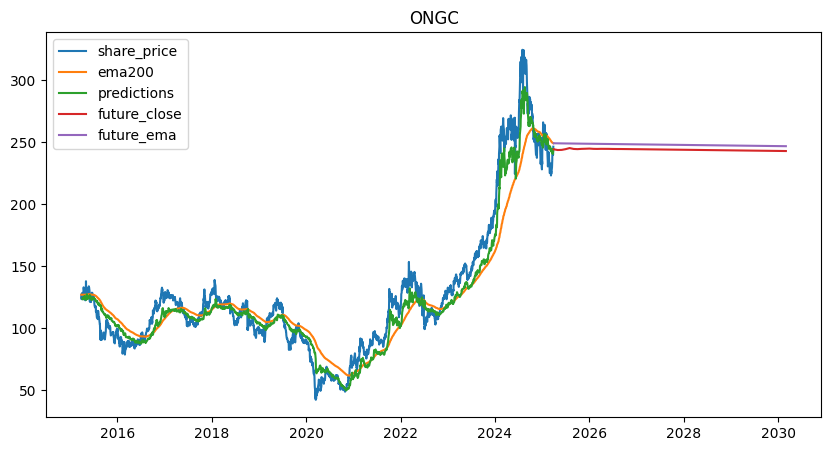

In [14]:
plt.figure(figsize=(10, 5))
plt.title(c_name)
plt.plot(pow_share_price_df.index, pow_share_price_df['Close'])
plt.plot(pow_share_price_df.index, pow_share_price_df['ema200'])
plt.plot(pow_result_df.index, pow_result_df['Close'])
plt.plot(pow_future_months, pow_future_close)
plt.plot(pow_future_months, pow_future_ema)
plt.legend(['share_price', 'ema200', 'predictions', 'future_close', 'future_ema'])

In [15]:
test_alpha = 2 / 201.0
test_val = np.expand_dims(pow_current_window, axis=0)
test_pred_close = model.predict(test_val)
test_pred_close_val = test_pred_close.flatten()[0]

test_last_ema = pow_current_window[-1, 1]
test_new_ema = (test_pred_close_val - test_last_ema) * test_alpha + test_last_ema
test_new_row = np.array([[test_pred_close_val, test_new_ema]])
test_pow_current_window = np.vstack([pow_current_window[1:], test_new_row])
print({'test_pred_close_val' : test_pred_close_val})
print({'test_last_ema' : test_last_ema})
print({'test_new_ema' : test_new_ema})
print({'test_new_row' : test_new_row})
print({'test_pow_current_window' : test_pow_current_window})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
{'test_pred_close_val': np.float32(242.86789)}
{'test_last_ema': np.float64(246.80884773690082)}
{'test_new_ema': np.float64(246.76963422115352)}
{'test_new_row': array([[242.8678894 , 246.76963422]])}
{'test_pow_current_window': array([[243.02452087, 246.92649174],
       [242.9853363 , 246.88727626],
       [242.94621277, 246.8480617 ],
       [242.90705872, 246.80884774],
       [242.8678894 , 246.76963422]])}
